In [1]:
%matplotlib inline

========================================
Using Xarray for Data read and selection
========================================

Use Xarray module to read in model data from nomads server.

This example uses the xarray module to access data from the nomads server for
archive NAM analysis data via OPeNDAP. Xarray makes it easier to select times
and levels, although you still have to know the coordinate variable name. A
simple 500 hPa plot is created after selecting with xarray.

Import all of our needed modules

In [2]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr

Accessing data using Xarray
---------------------------

In [3]:
# Set year, month, day, and hour values as variables to make it
# easier to change dates for a case study
base_url = 'https://www.ncei.noaa.gov/thredds/dodsC/namanl/'
dt = datetime(2016, 4, 16, 18)
data = xr.open_dataset('{}{dt:%Y%m}/{dt:%Y%m%d}/namanl_218_{dt:%Y%m%d}_'
                       '{dt:%H}00_000.grb'.format(base_url, dt=dt),
                       decode_times=True)

# To list all available variables for this data set,
# uncomment the following line
# print(sorted(list(data.variables)))

NAM data is in a projected coordinate and you get back the projection
X and Y values in km

In [4]:
# X, Y values are in units of km, need them in meters for plotting/calculations
data.x.values = data.x.values * 1000.
data.y.values = data.y.values * 1000.

# Make them 2D for plotting/calculations
x, y = np.meshgrid(data.x.values, data.y.values)

Getting the valid times in a more useable format

In [5]:
# Get the valid times from the file
vtimes = []
for t in range(data.time.size):
    vtimes.append(datetime.utcfromtimestamp(data.time[t].data.astype('O') / 1e9))
print(vtimes)

[datetime.datetime(2016, 4, 16, 18, 0)]


Xarray has some nice functionality to choose the time and level that
you specifically want to use. In this example the time variable is 'time' and
the level variable is 'isobaric1'. Unfortunately, these can be different with
each file you use, so you'll always need to check what they are by listing
the coordinate variable names

In [6]:
# print(data.Geopotential_height.coords)
hght_500 = data.Geopotential_height_isobaric.sel(time1=vtimes[0], isobaric=500)
uwnd_500 = data['u-component_of_wind_isobaric'].sel(time1=vtimes[0], isobaric=500)
vwnd_500 = data['v-component_of_wind_isobaric'].sel(time1=vtimes[0], isobaric=500)

Now make the 500-hPa map
------------------------

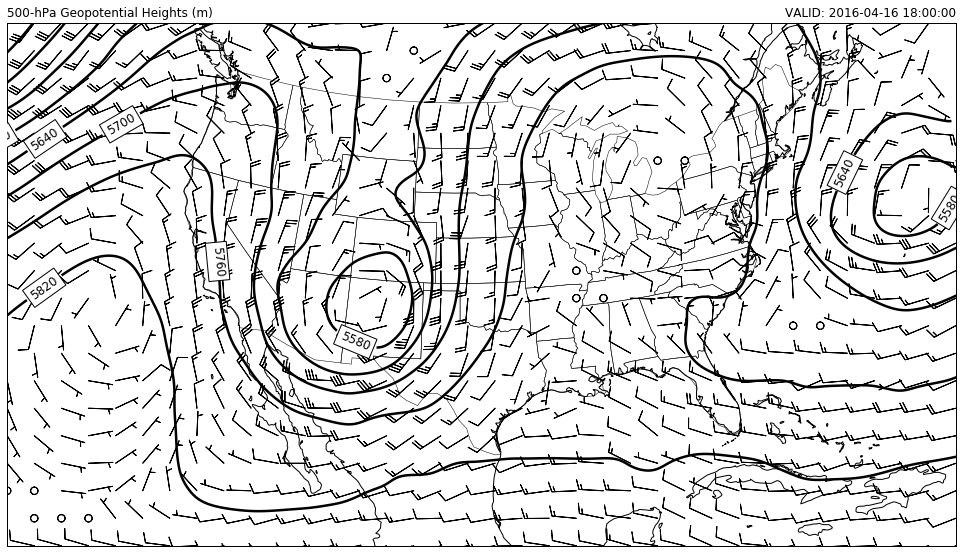

In [7]:
# Must set data projection, NAM is LCC projection
datacrs = ccrs.LambertConformal(
    central_latitude=data.LambertConformal_Projection.latitude_of_projection_origin,
    central_longitude=data.LambertConformal_Projection.longitude_of_central_meridian)

# A different LCC projection for the plot.
plotcrs = ccrs.LambertConformal(central_latitude=45., central_longitude=-100.,
                                standard_parallels=[30, 60])

fig = plt.figure(figsize=(17., 11.))
ax = plt.axes(projection=plotcrs)
ax.coastlines('50m', edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.set_extent([-130, -67, 20, 50], ccrs.PlateCarree())

clev500 = np.arange(5100, 6000, 60)
cs = ax.contour(x, y, ndimage.gaussian_filter(hght_500, sigma=5), clev500,
                colors='k', linewidths=2.5, linestyles='solid', transform=datacrs)
tl = plt.clabel(cs, fontsize=12, colors='k', inline=1, inline_spacing=8,
                fmt='%i', rightside_up=True, use_clabeltext=True)
# Here we put boxes around the clabels with a black boarder white facecolor
for t in tl:
    t.set_bbox({'fc': 'w'})

# Transform Vectors before plotting, then plot wind barbs.
ax.barbs(x, y, uwnd_500.data, vwnd_500.data, length=7, regrid_shape=20, transform=datacrs)

# Add some titles to make the plot readable by someone else
plt.title('500-hPa Geopotential Heights (m)', loc='left')
plt.title('VALID: {}'.format(vtimes[0]), loc='right')

plt.show()